In [135]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [136]:
os.environ["PYTHONHASHSEED"] = str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [137]:
model_path = r"C:\Users\91909\Desktop\ML\NTIRE_2025\tf_denoiser.h5"

clean_test_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"
noisy_test_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"

In [138]:
PATCH_SIZE = 256
OVERLAP = 64

In [139]:
def split_into_patches(image, patch_size=PATCH_SIZE, overlap=OVERLAP):
    """Splits an image into overlapping patches of size patch_size x patch_size."""
    h, w, c = image.shape
    step = patch_size - overlap
    patches = []
    coordinates = []

    for y in range(0, h - overlap, step):
        for x in range(0, w - overlap, step):
            y_end = min(y + patch_size, h)
            x_end = min(x + patch_size, w)
            patch = image[y:y_end, x:x_end]

            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                # Pad smaller patches to match expected size
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

            patches.append(patch)
            coordinates.append((y, x))
    
    return np.array(patches), coordinates

In [140]:
def predict_on_patches(model, patches):
    """Runs inference on all patches and returns RGB predictions."""
    patches = patches.astype(np.float32) / 255.0  # Normalize
    predictions = model.predict(patches)
    predictions = np.clip(predictions * 255.0, 0, 255).astype(np.uint8)  # Convert back to image format
    return predictions

In [141]:
def stitch_patches(patches, coordinates, image_shape, patch_size=PATCH_SIZE, overlap=OVERLAP):
    """Reconstructs the full RGB image from patches using averaging at overlapping areas."""
    h, w, c = image_shape
    step = patch_size - overlap
    stitched_image = np.zeros((h, w, 3))
    weight_map = np.zeros((h, w, 1))

    for patch, (y, x) in zip(patches, coordinates):
        y_end = min(y + patch_size, h)
        x_end = min(x + patch_size, w)
        patch_h = y_end - y
        patch_w = x_end - x

        stitched_image[y:y_end, x:x_end] += patch[:patch_h, :patch_w]
        weight_map[y:y_end, x:x_end] += 1

    return np.clip(stitched_image / weight_map, 0, 255).astype(np.uint8)

3/3 [==============================] - 3s 1s/step


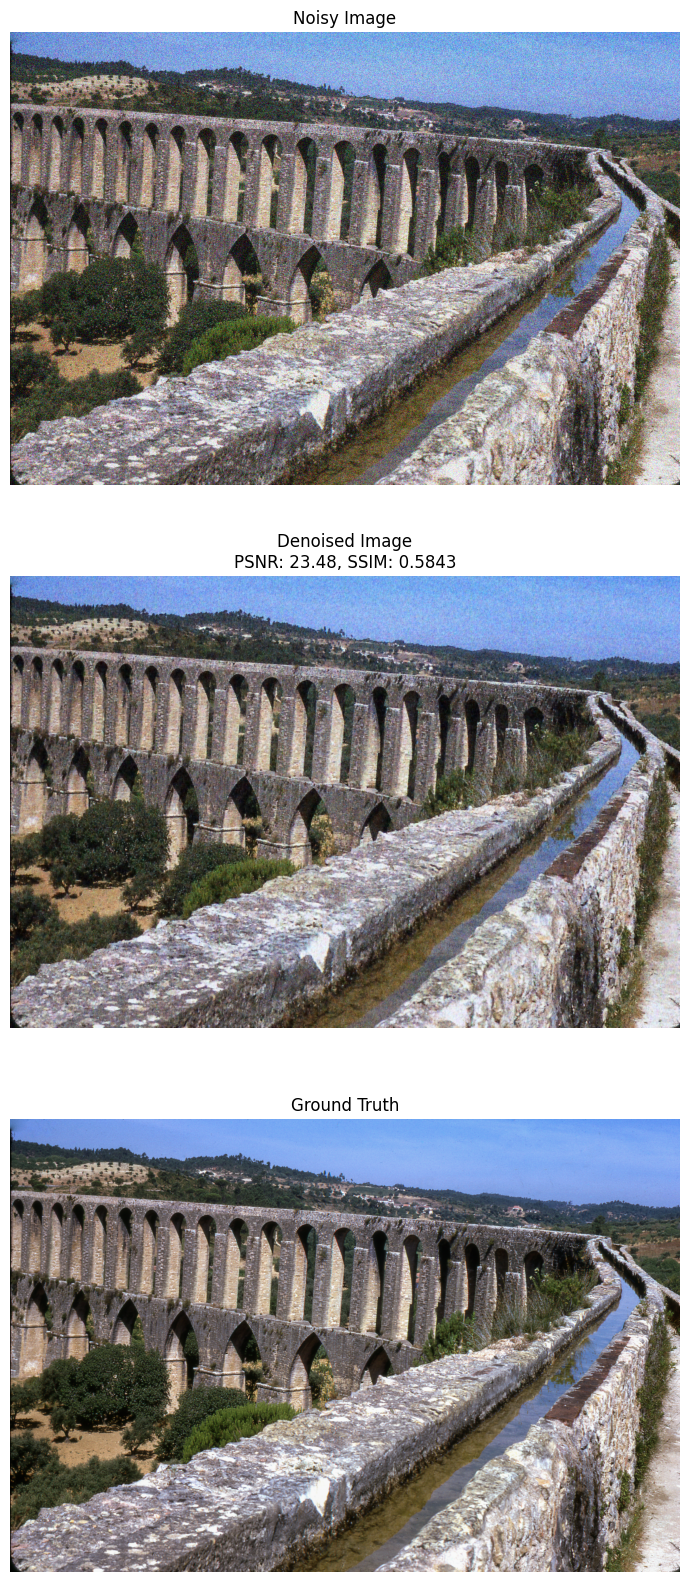

In [169]:
model = load_model(model_path)

# Pick a random image from the noisy folder
file_list = os.listdir(noisy_test_path)
random_file = np.random.choice(file_list)

noisy_image_path = os.path.join(noisy_test_path, random_file)
clean_image_path = os.path.join(clean_test_path, random_file)

# Load and process images
noisy_image = cv2.imread(noisy_image_path)
noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)

clean_image = cv2.imread(clean_image_path)
clean_image = cv2.cvtColor(clean_image, cv2.COLOR_BGR2RGB)

# Split into patches, predict, and stitch back
patches, coordinates = split_into_patches(noisy_image)
predictions = predict_on_patches(model, patches)
denoised_image = stitch_patches(predictions, coordinates, noisy_image.shape)

# Compute metrics
psnr_value = psnr(clean_image, denoised_image, data_range=255)
ssim_value = ssim(clean_image, denoised_image, data_range=255, channel_axis=2)

# Plot results
plt.figure(figsize=(10, 20))

plt.subplot(3, 1, 1)
plt.imshow(noisy_image)
plt.title("Noisy Image")
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(denoised_image)
plt.title(f"Denoised Image\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(clean_image)
plt.title("Ground Truth")
plt.axis("off")

plt.show()

In [170]:
noisy_image.shape

(1380, 2040, 3)

In [171]:
clean_image.shape

(1380, 2040, 3)

In [172]:
denoised_image.shape

(1380, 2040, 3)

In [143]:
def main(model_path, image_path):
    model = tf.keras.models.load_model(model_path, compile=False)

    # Load and process image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Patch-based prediction
    patches, coordinates = split_into_patches(image)
    predictions = predict_on_patches(model, patches)
    stitched_image = stitch_patches(predictions, coordinates, image.shape)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(stitched_image)
    plt.title("Denoised Image")
    plt.axis("off")

    plt.show()

In [144]:
test_image = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\test\LSDIR_DIV2K_Test_Sigma50\0000089.png"

1/1 [==============================] - 0s 487ms/step


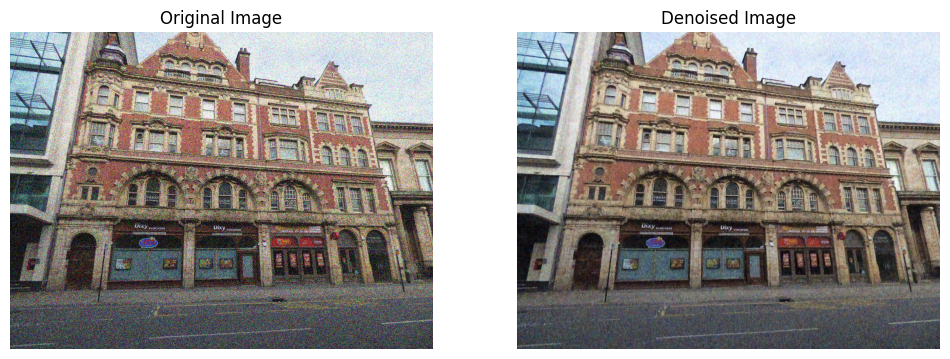

In [145]:
main(model_path, test_image)

3/3 [==============================] - 3s 1s/step


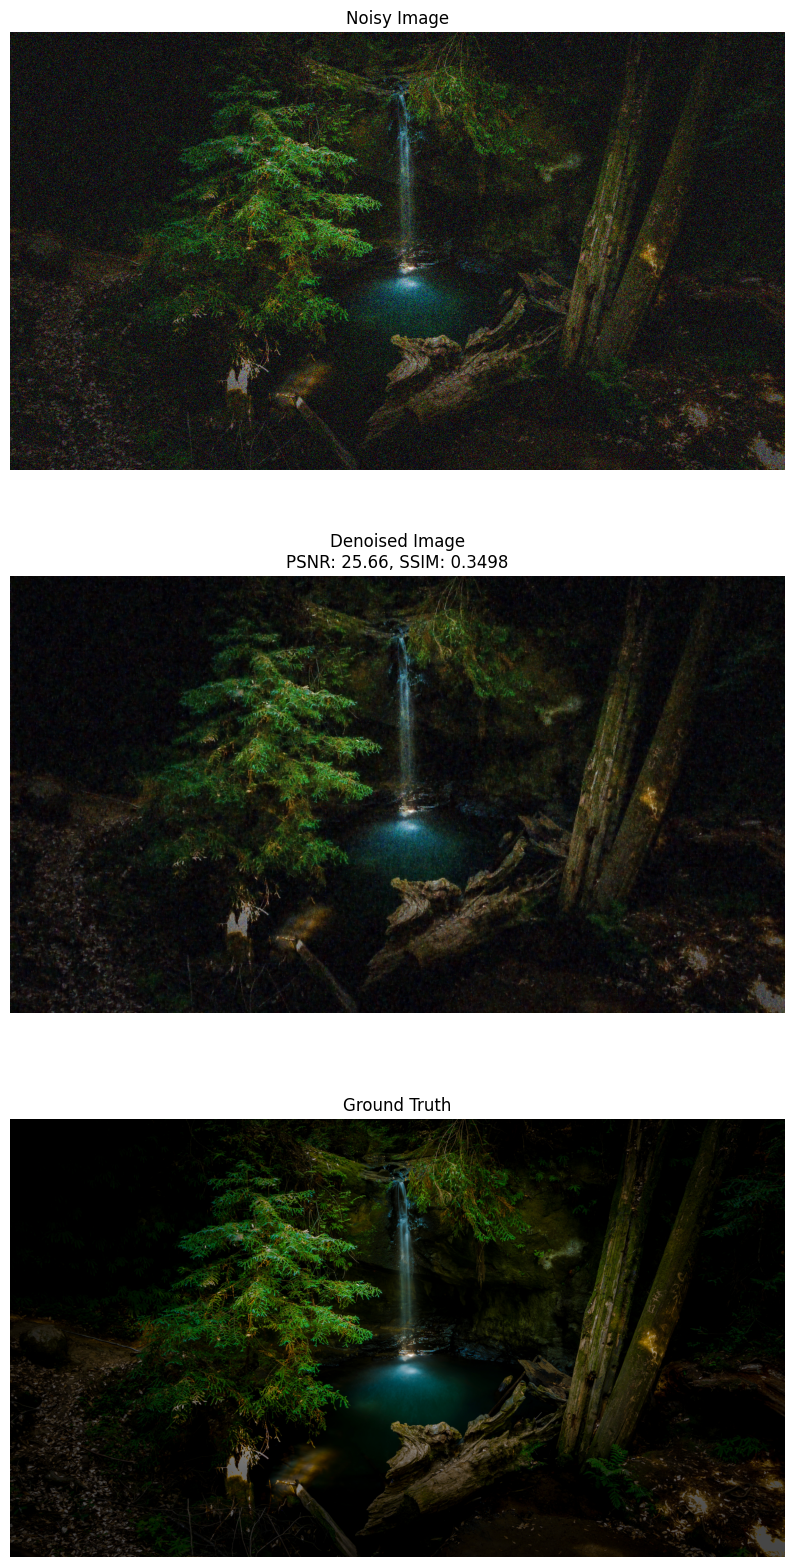

In [146]:
process_and_evaluate(model_path, clean_test_path, noisy_test_path)